<a href="https://colab.research.google.com/github/jaemin-capslock/Bounding-Box-Annotator/blob/main/CSE150_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install pyreadstat
!pip install pgmpy


In [49]:
!wget https://www.samhsa.gov/data/system/files/media-puf-file/NSDUH-2023-DS0001-bndl-data-tsv_v1.zip

--2025-02-17 06:27:12--  https://www.samhsa.gov/data/system/files/media-puf-file/NSDUH-2023-DS0001-bndl-data-tsv_v1.zip
Resolving www.samhsa.gov (www.samhsa.gov)... 158.71.215.157, 158.71.215.158
Connecting to www.samhsa.gov (www.samhsa.gov)|158.71.215.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29033143 (28M) [application/zip]
Saving to: ‘NSDUH-2023-DS0001-bndl-data-tsv_v1.zip.1’

NSDUH-2023-DS0001-b 100%[===================>]  27.69M  26.1MB/s    in 1.1s    

2025-02-17 06:27:14 (26.1 MB/s) - ‘NSDUH-2023-DS0001-bndl-data-tsv_v1.zip.1’ saved [29033143/29033143]



In [ ]:
!unzip -j NSDUH-2023-DS0001-bndl-data-tsv_v1.zip "*.txt" -d .

Archive:  NSDUH-2023-DS0001-bndl-data-tsv_v1.zip
replace ./NSDUH_2023_Tab.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd

df = pd.read_csv('NSDUH_2023_Tab.txt', sep='\t', header=0)

In [ ]:
# df.describe()

In [ ]:
# Pick columns
desired_columns = [
    "AGE3",       # Age category
    "SERVICE",    # U.S. Army?
    "IRSEX",      # Respondent sex
    "IRMARIT",    # Marital status
    "NEWRACE2",   # Race
    "IREDUHIGHST2", # Education level (1-11)
    "BOOKED",     # Ever arrested? (1=Yes,2=No)
    "CIG30USE",   # Cigarette use in past 30 days
    "NICVAPEVER", # Ever vaped nicotine
    "CADRLAST",   # # of drinks in past 30 days
    "ALCDAYS",    # # of days w/ alc past 30 days
    "MJEVER",     # Ever used marijuana
    "MJAGE",      # Age first used MJ
    "MJYRTOT",    # # of years used MJ
    "MJDAY30A",   # # of days used MJ in past 30
    "COCEVER",    # Ever used cocaine
    "HEREVER",    # Ever used heroin
    "LSD",        # Ever used LSD
    "PSILCY",     # Ever used psilocybin
    "ECSTMOLLY",  # Ecstasy/Molly
    "METHAMEVR",  # Ever used meth
    "METHAMYFQ",  # Frequency of meth use
    "TRBZOANYYR", # Benzo use in last year
    "IRALCBNG30D", # Binge drinking
    "MICATPY", # Past year mental illness, (0=No, 1=Mild, 2=Moderate, 3=Severe)
    "AMDELT", #MDE
    "IRAMDELT", #lifetime MDE
    "CONEGMH", # COVID and mental health
    "DIFGET"
]

In [ ]:
irpyud5_columns = [col for col in df.columns if col.startswith("IRPYUD5")]
desired_columns.extend(irpyud5_columns)

In [ ]:
#df_filtered[irpyud5_columns]

In [ ]:
import numpy as np
df_filtered = df[desired_columns].copy()


substance_code_mapping = {91: 0, 991: 0, 93: 0, 993: 0, 94: np.nan, 97: np.nan}
substance_columns = [
    "CIG30USE","MJEVER", "COCEVER", "HEREVER", "LSD", "PSILCY", "ECSTMOLLY", "METHAMEVR",
    "IRALCBNG30D", "METHAMYFQ", "TRBZOANYYR", "NICVAPEVER", "CADRLAST", "MJDAY30A", "ALCDAYS"
    ]
for col in substance_columns: df_filtered[col] = df_filtered[col].replace(substance_code_mapping)
missing_codes = [81, 981, 85, 985, 94, 994, 95, 995, 97, 997, 98, 998, 99, 999]  # Example set; confirm in codebook
for col in df_filtered.columns:
    df_filtered[col] = df_filtered[col].replace(missing_codes, np.nan)


df_filtered["IRSEX"] = df_filtered["IRSEX"].map({1: "Male", 2: "Female"})
df_filtered["BOOKED"] = df_filtered["BOOKED"].map({1: "Yes", 2: "No"})
df_filtered["IREDUHIGHST2"] = df_filtered["IREDUHIGHST2"].map({1: "Less than HS",
                                                               2: "Less than HS",
                                                               3: "Less than HS",
                                                               4: "Less than HS",
                                                               5: "Less than HS",
                                                               6: "Less than HS",
                                                               7: "Less than HS",
                                                               8: "HS",
                                                               9: "Some college credit",
                                                               10: "Associates",
                                                               11: "Bachelors or higher"})

df_filtered["SERVICE"] = df_filtered["SERVICE"].map({1: "Yes", 2: "No"})
df_filtered['AGE3'] = df_filtered['AGE3'].map({
    1: "12-13",
    2: "14-15",
    3: "16-17",
    4: "18-20",
    5: "21-23",
    6: "24-25",
    7: "26-29",
    8: "30-34",
    9: "35-49",
    10: "50-64",
    11: "65-"
})
df_filtered["IRMARIT"] = df_filtered["IRMARIT"].map({
    1: "Married",
    2: "Widowed",
    3: "Divorced or separated",
    4: "Never married"})
df_filtered["NEWRACE2"] = df_filtered["NEWRACE2"].map({
   1: "White",
   2: "Black",
   3: "Native",
   4: "Pacific Islander",
   5: "Asian",
   6: "More than one race",
   7: "Hispanic"
})

In [ ]:
df_filtered.describe()

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split

# Categorize using bins
df_bn = df_filtered.copy()

df_bn['CADRLAST'] = pd.to_numeric(df_bn['CADRLAST'], errors='coerce')
df_bn['CADRLAST_cat'] = pd.cut(df_bn['CADRLAST'], bins=[-1, 0, 5, 15, np.inf], labels=["None", "Low", "Medium", "High"])
df_bn['ALCDAYS'] = pd.to_numeric(df_bn['ALCDAYS'], errors='coerce')
df_bn['ALCDAYS_cat'] = pd.cut(df_bn['ALCDAYS'], bins=[-1, 0, 4, 10, 20, np.inf], labels=["None", "Low", "Medium", "High", "Very High"])
df_bn['MJDAY30A'] = pd.to_numeric(df_bn['MJDAY30A'], errors='coerce')
df_bn['MJDAY30A_cat'] = pd.cut(df_bn['MJDAY30A'], bins=[-1, 0, 4, 10, 20, np.inf], labels=["None", "Low", "Medium", "High", "Very High"])

df_bn['CIG30USE'] = pd.to_numeric(df_bn['CIG30USE'], errors='coerce')
df_bn['CIG30USE_cat'] = pd.cut(df_bn['CIG30USE'], bins=[-1, 0, 4, 10, 20, np.inf], labels=["None", "Low", "Medium", "High", "Very High"])

#variables_bn = ['AGE3', 'IRSEX', 'NEWRACE2', 'IREDUHIGHST2', 'CADRLAST_cat', 'MJEVER', 'AMDELT',"NICVAPEVER", "CADRLAST", "MJDAY30A_cat","METHAMEVR", "MICATPY"]
variables_bn = ['AGE3', 'IRSEX', 'NEWRACE2', 'IREDUHIGHST2', 'CADRLAST_cat', 'AMDELT',"NICVAPEVER", "CADRLAST", "MJDAY30A_cat", "MICATPY", "ALCDAYS_cat", "CIG30USE_cat"]
sud_variables_bn = df_bn[irpyud5_columns].dropna().copy()
variables_bn.extend(sud_variables_bn)
bn_data = df_bn[variables_bn].dropna().copy()

for col in bn_data.columns:
    bn_data[col] = bn_data[col].astype(str)


train_data, test_data = train_test_split(bn_data, test_size=0.15, random_state=42)
hc = HillClimbSearch(train_data)
learned_dag = hc.estimate(scoring_method=BicScore(train_data))
print("Learned DAG edges:")
print(learned_dag.edges())


G = BayesianNetwork(learned_dag.edges())

G.fit(train_data, estimator=MaximumLikelihoodEstimator)



In [ ]:

bic = BicScore(test_data)
test_bic_score = bic.score(G)
print("Test Data BIC Score:", test_bic_score)

inference = VariableElimination(G)

query_result = inference.query(variables=['AMDELT'], evidence={'IRSEX': 'Male', 'CADRLAST_cat': 'High'})
print("\nProbability distribution for depression (AMDELT) given Male and High alcohol consumption:")
print(query_result)

In [ ]:

smi_query = inference.query(variables=['MICATPY'], evidence={'IRSEX': 'Male', 'MJDAY30A_cat': 'Medium'})
print(smi_query)


In [ ]:
bn_data['METHAMEVR'][0]

In [41]:

inference = VariableElimination(G)


categories = ['Low', 'Medium', 'High', 'Very high']
gender = ['Male', 'Female']
ME = ['1.0', '2.0']
results = {}
for gen in gender:
    for m in ME:
        for cat in categories:
            query_result = inference.query(
                variables=['MICATPY'],
                evidence={'IRSEX': gen, 'MJDAY30A_cat': cat, 'METHAMEVR': m}
            )
            key = (gen, m, cat)
            results[key] = pd.Series(query_result.values, index=query_result.state_names['MICATPY'])

# Combine the Series into a DataFrame.
results_df = pd.DataFrame(results).T
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['IRSEX', 'METHAMEVR', 'MJDAY30A_cat'])

print(results_df)


                                    0.0       1.0       2.0       3.0
IRSEX  METHAMEVR MJDAY30A_cat                                        
Male   1.0       Low           0.617661  0.145352  0.109238  0.127749
                 Medium        0.654280  0.159450  0.072309  0.113961
                 High          0.580338  0.124423  0.137190  0.158050
                 Very high     0.618053  0.158702  0.101390  0.121855
       2.0       Low           0.801705  0.098772  0.051892  0.047631
                 Medium        0.759941  0.130920  0.045842  0.063297
                 High          0.707524  0.107956  0.091998  0.092523
                 Very high     0.731511  0.133729  0.066084  0.068676
Female 1.0       Low           0.476696  0.171960  0.150941  0.200403
                 Medium        0.422184  0.167452  0.184690  0.225673
                 High          0.460241  0.205515  0.135793  0.198450
                 Very high     0.418347  0.169726  0.174172  0.237755
       2.0       Low

In [ ]:

gender = ['Male', 'Female']
ME = ['1.0', '2.0']
results = {}
for gen in gender:
    for m in ME:
        for cat in categories:
            query_result = inference.query(
                variables=['MICATPY'],
                evidence={'IRSEX': gen, 'MJDAY30A_cat': cat, 'METHAMEVR': m}
            )
            key = (gen, m, cat)
            results[key] = pd.Series(query_result.values, index=query_result.state_names['MICATPY'])

# Combine the Series into a DataFrame.
results_df = pd.DataFrame(results).T
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['IRSEX', 'METHAMEVR', 'MJDAY30A_cat'])

print(results_df)

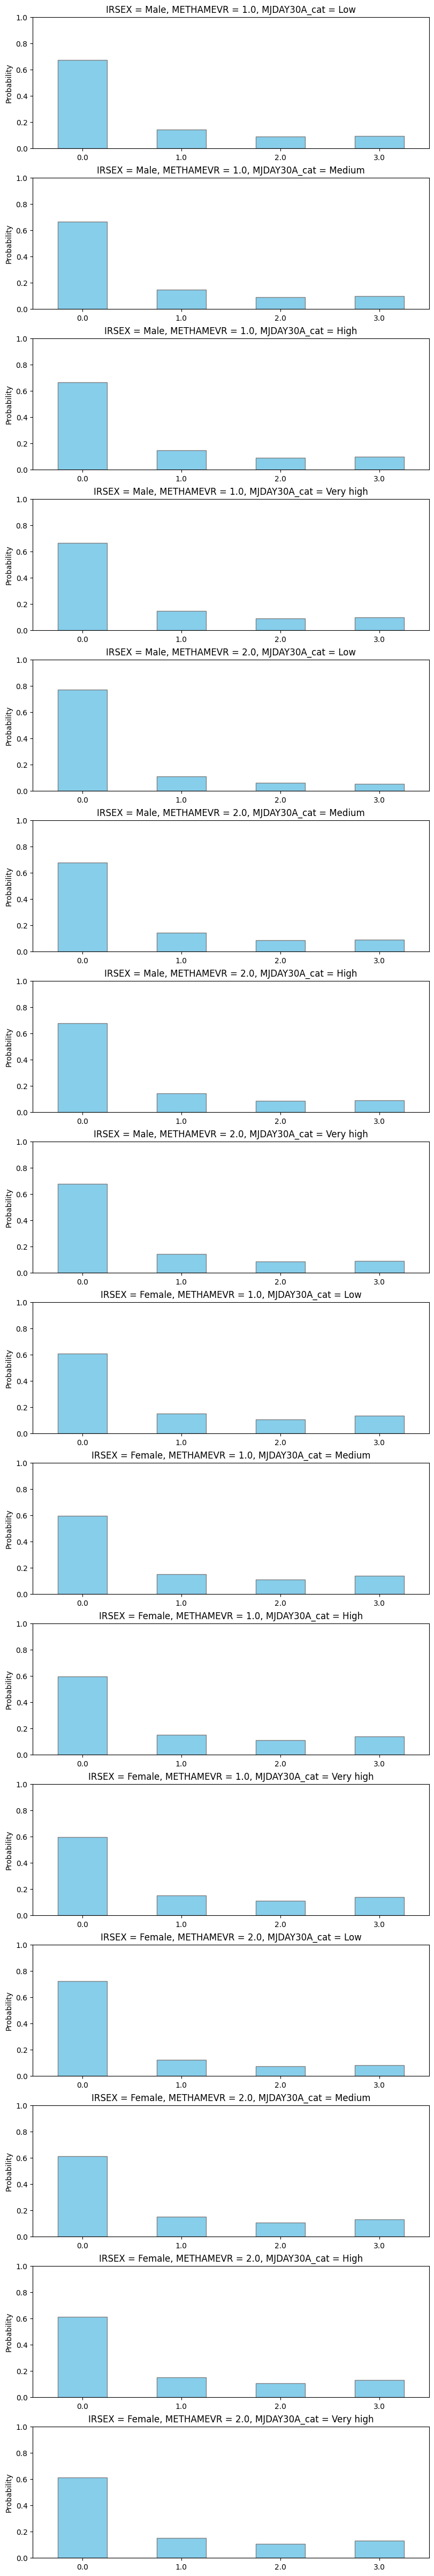

In [31]:
import matplotlib.pyplot as plt
n_plots = len(results)
fig, axes = plt.subplots(n_plots, 1, figsize=(8, n_plots * 3), constrained_layout=True)

# If only one plot is present, wrap axes in a list.
if n_plots == 1:
    axes = [axes]

for ax, ((gen, m, cat), prob_series) in zip(axes, results.items()):
    # Plot a bar chart with light colors and edges.
    prob_series.plot(kind='bar', ax=ax, color='skyblue', edgecolor='gray', linewidth=1)
    ax.set_title(f'IRSEX = {gen}, METHAMEVR = {m}, MJDAY30A_cat = {cat}')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)  # Since probabilities range from 0 to 1

    ax.tick_params(axis='x', rotation=0)

plt.show()


In [ ]:
df_filtered["NEWRACE2"].value_counts()

In [ ]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df_filtered["NEWRACE2"], df_filtered["MJEVER"])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print("Chi-square test: chi2 =", chi2, "p-value =", p)

In [ ]:
df_filtered.to_csv('nsduh_2023_filtered.csv', index=False)

In [ ]:
with open('nsduh_2023.tsv') as f:
    print(f)